# ResNet image classifier baseline to assess how useful static RGB player images are for hit detection.





In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/MyDrive/badminton/

/content/gdrive/MyDrive/badminton


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data
from torch.utils.data import Dataset

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import shutil
import time
import pandas as pd
import natsort
from PIL import Image

In [4]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Hyperparameters

In [5]:
VALID_RATIO = 0.75
OUTPUT_DIM = 3
weights_path = 'resnet_data/resnet_nov_15epoch_indv_clearnohit.pt'

## ResNet-50 model

In [6]:
class ResNet(nn.Module):
    def __init__(self, config, output_dim):
        super().__init__()
                
        block, n_blocks, channels = config
        self.in_channels = channels[0]
            
        assert len(n_blocks) == len(channels) == 4
        
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride = 2)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride = 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)
        
    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):
    
        layers = []
        
        if self.in_channels != block.expansion * channels:
            downsample = True
        else:
            downsample = False
        
        layers.append(block(self.in_channels, channels, stride, downsample))
        
        for i in range(1, n_blocks):
            layers.append(block(block.expansion * channels, channels))

        self.in_channels = block.expansion * channels
            
        return nn.Sequential(*layers)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        
        return x, h

In [7]:
class Bottleneck(nn.Module):
    
    expansion = 4
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
    
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                               stride = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size = 1,
                               stride = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(self.expansion * out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
            
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
                
        if self.downsample is not None:
            i = self.downsample(i)
            
        x += i
        x = self.relu(x)
    
        return x

In [8]:
# namedtuple
ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])

In [9]:
# set up resnet-50
resnet50_config = ResNetConfig(block = Bottleneck,
                               n_blocks = [3, 4, 6, 3],
                               channels = [64, 128, 256, 512])

## Load player crops stored in format data_indvcrops/{train, test}/{0,1,2}/0.jpg

In [ ]:
!rm -r resnet_data/data_indvcrops

In [ ]:
# need to apply all the time?yy
!unzip -o data_indvcrops.zip -d resnet_data/

Streaming output truncated to the last 5000 lines.
  inflating: data_indvcrops/train/2/match22_2_18_18_far_506.jpg  
  inflating: data_indvcrops/train/2/match22_2_18_18_far_509.jpg  
  inflating: data_indvcrops/train/2/match22_3_15_13_far_105.jpg  
  inflating: data_indvcrops/train/2/match22_3_15_13_far_106.jpg  
  inflating: data_indvcrops/train/2/match22_3_15_13_far_186.jpg  
  inflating: data_indvcrops/train/2/match22_3_15_13_far_188.jpg  
  inflating: data_indvcrops/train/2/match22_3_15_13_far_231.jpg  
  inflating: data_indvcrops/train/2/match22_3_15_13_far_309.jpg  
  inflating: data_indvcrops/train/2/match22_3_15_13_far_64.jpg  
  inflating: data_indvcrops/train/2/match23_1_06_04_far_124.jpg  
  inflating: data_indvcrops/train/2/match23_1_06_04_far_180.jpg  
  inflating: data_indvcrops/train/2/match23_1_06_04_far_183.jpg  
  inflating: data_indvcrops/train/2/match23_1_06_04_far_213.jpg  
  inflating: data_indvcrops/train/2/match23_1_06_04_far_215.jpg  
  inflating: data_indvcrop

In [ ]:
# directory structure in the form train/label/xxx.jpg
train_dir = 'resnet_data/data_indvcrops/train/'
test_dir = 'resnet_data/data_indvcrops/test/'

## Loading dataset for training and testing

In [ ]:
# pretrained params
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

# data augmentation
train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(pretrained_size, padding = 10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.CenterCrop(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

In [ ]:
# loading dataset
train_data = datasets.ImageFolder(root = train_dir, 
                                  transform = train_transforms)

test_data = datasets.ImageFolder(root = test_dir, 
                                 transform = test_transforms)

In [ ]:
# create validation split

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])

In [ ]:
# overwrite the validation transforms, making sure to do a deepcopy to stop this also changing the training data transforms
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [ ]:
# sanity check
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 17514
Number of validation examples: 5838
Number of testing examples: 3843


In [ ]:
# load iterators, 64 should fit into GPU

BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data, 
                                batch_size = BATCH_SIZE)

### plot images for sanity check

In [ ]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image    

In [ ]:
def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):
      ax = fig.add_subplot(rows, cols, i+1)
      image = images[i]
      label = labels[i]
      image = image.permute(1, 2, 0)

      if normalize:
            image = normalize_image(image)

      ax.imshow(image.cpu().numpy())
      ax.set_title(label)
      ax.axis('off')
      

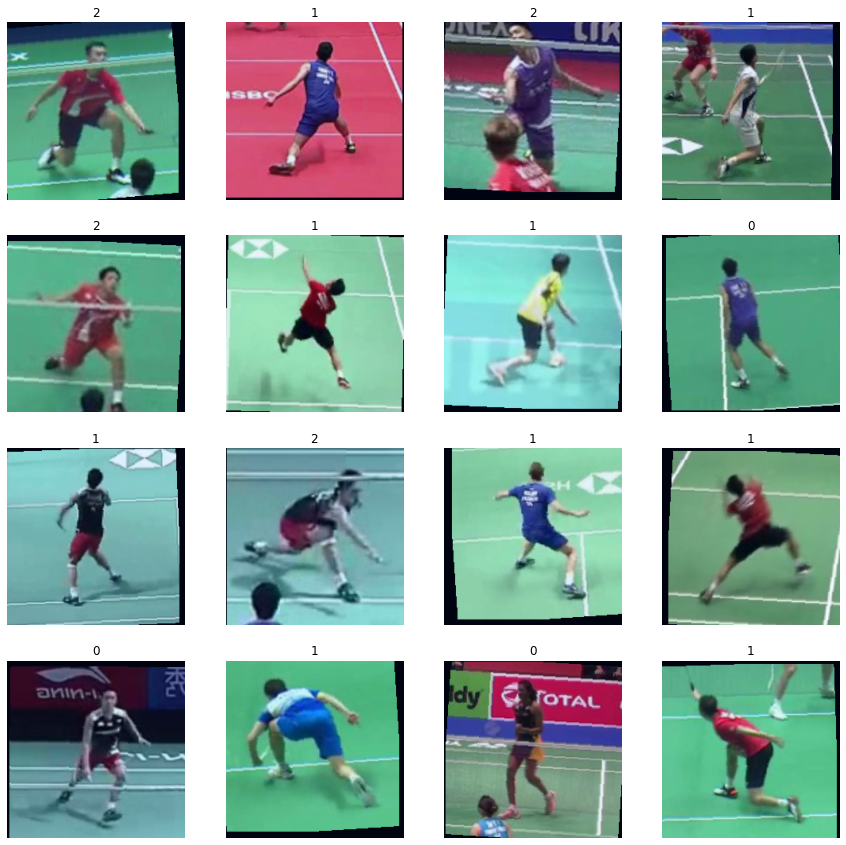

In [ ]:
N_IMAGES = 16

images, labels = zip(*[(image, label) for image, label in [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

plot_images(images, labels, classes)

## Define model

In [ ]:
pretrained_model = models.resnet50(pretrained = True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
print(pretrained_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Replace last layer of 1000 classes with 3 classes

IN_FEATURES = pretrained_model.fc.in_features 
OUTPUT_DIM = len(test_data.classes)

fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)

In [ ]:
pretrained_model.fc = fc

In [ ]:
model = ResNet(resnet50_config, OUTPUT_DIM)

In [ ]:
# load params into model
model.load_state_dict(pretrained_model.state_dict())

<All keys matched successfully>

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 23,514,179 trainable parameters


## Training the model

### Find optimal learning rate

In [ ]:
START_LR = 1e-7

optimizer = optim.Adam(model.parameters(), lr=START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):
        
        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device
        
        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr = 10, num_iter = 100, 
                   smooth_f = 0.05, diverge_th = 5):
        
        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        
        iterator = IteratorWrapper(iterator)
        
        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            #update lr
            lr_scheduler.step()
            
            lrs.append(lr_scheduler.get_lr()[0])

            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]
                
            if loss < best_loss:
                best_loss = loss

            losses.append(loss)
            
            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break
                       
        #reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))
                    
        return lrs, losses

    def _train_batch(self, iterator):
        
        self.model.train()
        
        self.optimizer.zero_grad()
        
        x, y = iterator.get_batch()
        
        x = x.to(self.device)
        y = y.to(self.device)
        
        y_pred, _ = self.model(x)
                
        loss = self.criterion(y_pred, y)
        
        loss.backward()
        
        self.optimizer.step()
        
        return loss.item()

class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

In [ ]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_iterator, END_LR, NUM_ITER)

Stopping early, the loss has diverged


In [ ]:
def plot_lr_finder(lrs, losses, skip_start = 5, skip_end = 5):
    
    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]
    
    fig = plt.figure(figsize = (16,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

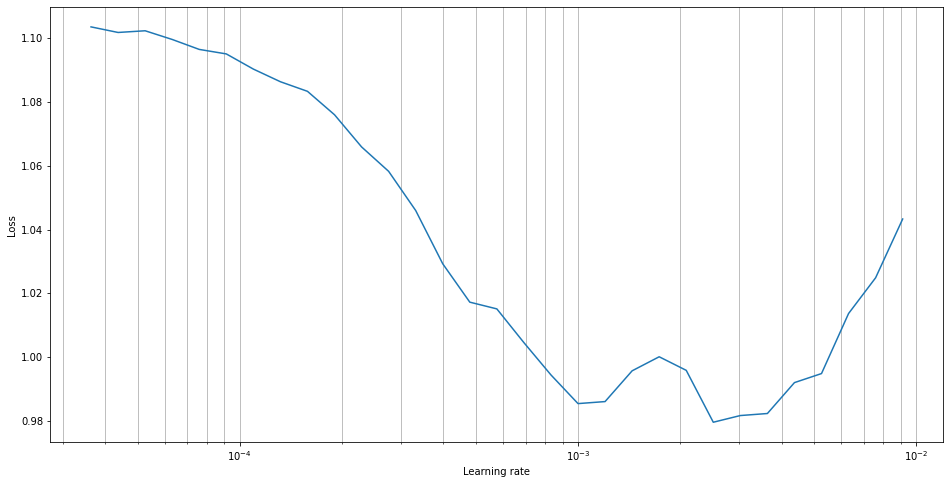

In [ ]:
# plot graph to find max learning rate that results in minimal loss
plot_lr_finder(lrs, losses, skip_start = 30, skip_end = 30)

In [ ]:
FOUND_LR = 1e-3 # TO FILL IN BASED ON GRAPH

params = [
          {'params': model.conv1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.bn1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.layer1.parameters(), 'lr': FOUND_LR / 8},
          {'params': model.layer2.parameters(), 'lr': FOUND_LR / 6},
          {'params': model.layer3.parameters(), 'lr': FOUND_LR / 4},
          {'params': model.layer4.parameters(), 'lr': FOUND_LR / 2},
          {'params': model.fc.parameters()}
         ]


optimizer = optim.Adam(params, lr = FOUND_LR)

In [ ]:
EPOCHS = 15 # TO BE ADJUSTED
STEPS_PER_EPOCH = len(train_iterator)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr = MAX_LRS,
                                    total_steps = TOTAL_STEPS)

In [ ]:
def calculate_topk_accuracy(y_pred, y, k = 1): # dunnid top k, since only 3 classes
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

### helper functions for training/evaluation

In [ ]:
def train(model, iterator, optimizer, criterion, scheduler, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred, _ = model(x)
        
        loss = criterion(y_pred, y)
        
        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [ ]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### start training

In [ ]:
best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc_1, train_acc_5 = train(model, train_iterator, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, valid_iterator, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), weights_path)

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')

Epoch: 01 | Epoch Time: 5m 11s
	Train Loss: 0.528 | Train Acc @1:  76.07% | Train Acc @5:  76.07%
	Valid Loss: 0.360 | Valid Acc @1:  85.14% | Valid Acc @5:  85.14%
Epoch: 02 | Epoch Time: 4m 59s
	Train Loss: 0.338 | Train Acc @1:  86.28% | Train Acc @5:  86.28%
	Valid Loss: 0.363 | Valid Acc @1:  87.70% | Valid Acc @5:  87.70%
Epoch: 03 | Epoch Time: 5m 0s
	Train Loss: 0.307 | Train Acc @1:  88.26% | Train Acc @5:  88.26%
	Valid Loss: 0.301 | Valid Acc @1:  88.79% | Valid Acc @5:  88.79%
Epoch: 04 | Epoch Time: 4m 59s
	Train Loss: 0.278 | Train Acc @1:  89.33% | Train Acc @5:  89.33%
	Valid Loss: 0.544 | Valid Acc @1:  81.97% | Valid Acc @5:  81.97%
Epoch: 05 | Epoch Time: 5m 1s
	Train Loss: 0.249 | Train Acc @1:  90.60% | Train Acc @5:  90.60%
	Valid Loss: 0.326 | Valid Acc @1:  87.56% | Valid Acc @5:  87.56%
Epoch: 06 | Epoch Time: 5m 0s
	Train Loss: 0.213 | Train Acc @1:  92.13% | Train Acc @5:  92.13%
	Valid Loss: 0.342 | Valid Acc @1:  86.30% | Valid Acc @5:  86.30%
Epoch: 07 | E

## Test model

In [ ]:
model.load_state_dict(torch.load(weights_path))

test_loss, test_acc_1, test_acc_5 = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc @1: {test_acc_1*100:6.2f}% | ' \
      f'Test Acc @5: {test_acc_5*100:6.2f}%')

Test Loss: 0.355 | Test Acc @1:  87.40% | Test Acc @5:  87.40%


### Examine the model

In [ ]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [ ]:
images, labels, probs = get_predictions(model, test_iterator)

In [ ]:
pred_labels = torch.argmax(probs, 1)

#### confusion matrix

In [ ]:
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    fig.delaxes(fig.axes[1]) #delete colorbar
    plt.xticks(rotation = 90)
    plt.xlabel('Predicted Label', fontsize = 50)
    plt.ylabel('True Label', fontsize = 50)

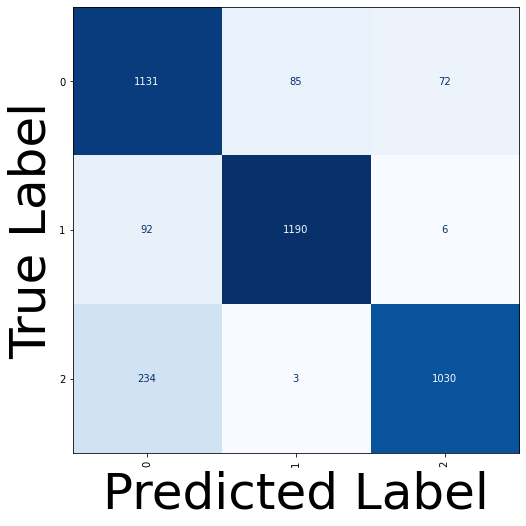

In [ ]:
classes = test_data.classes
plot_confusion_matrix(labels, pred_labels, classes)

#### find most incorrect

In [ ]:
corrects = torch.eq(labels, pred_labels)

In [ ]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

In [ ]:
def plot_most_incorrect(incorrect, classes, n_images, normalize = True):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (25, 20))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        true_class = classes[true_label]
        incorrect_class = classes[incorrect_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
        ax.axis('off')
        
    fig.subplots_adjust(hspace=0.4)

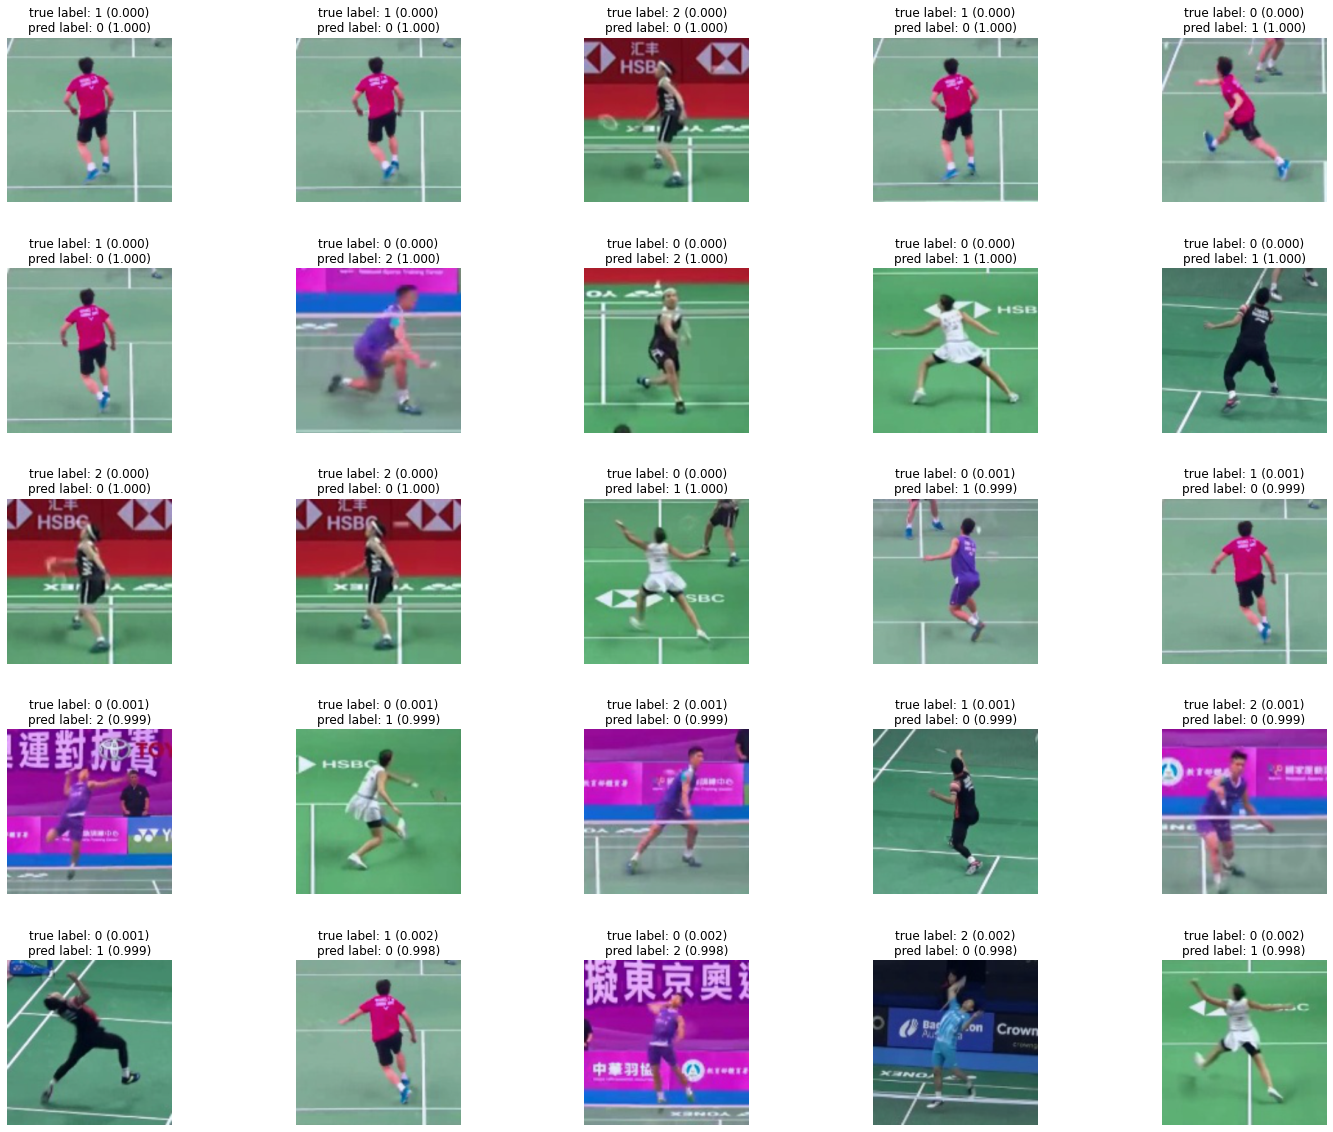

In [ ]:
N_IMAGES = 25

plot_most_incorrect(incorrect_examples, classes, N_IMAGES)

# Inference on videos

Save predicted probability for each frame.

Out: test_match1/1_05_02_probs.npy

## Load model

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet(resnet50_config, OUTPUT_DIM)
model.load_state_dict(torch.load(weights_path))
model = model.to(device)
model.eval() # IMPT, or will yield inconsistent inference results

FileNotFoundError: ignored

In [27]:
!ls resnet_data

data_indvcrops_clearnohit.zip  resnet_nov_15epoch_indv.pt


## load directory with test frames

In [23]:
class CustomDataSet(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsort.natsorted(all_imgs) # ensures imgs in natural numerical order

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image

In [11]:
def load_iterator(test_dir):
  # pretrained params
  pretrained_size = 224
  pretrained_means = [0.485, 0.456, 0.406]
  pretrained_stds= [0.229, 0.224, 0.225]

  test_transforms = transforms.Compose([
                            transforms.Resize(pretrained_size),
                            transforms.CenterCrop(pretrained_size),
                            transforms.ToTensor(),
                            transforms.Normalize(mean = pretrained_means, 
                                                  std = pretrained_stds)
                        ])
  test_data = CustomDataSet(test_dir, transform = test_transforms)

  BATCH_SIZE = 64

  test_iterator = data.DataLoader(test_data, 
                                  batch_size = BATCH_SIZE)
  
  return test_iterator

## get predictions

In [12]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    probs = []

    with torch.no_grad():

        for x in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, probs

## sort predictions according to frame order

In [13]:
def get_imgind_sorted(dirpath):
  all_imgs = os.listdir(dirpath)
  sorted_index = natsort.index_natsorted(all_imgs)

  return sorted_index

## save pred probs for input vid

In [14]:
def output_pred_probs(model, test_dir):
  test_iterator = load_iterator(test_dir)
  images, probs = get_predictions(model, test_iterator)

  sorted_idx = get_imgind_sorted(test_dir)
  probs_sorted = np.array(probs[sorted_idx])

  return probs_sorted


## save pred probs in csv for all vids

In [15]:
!unzip input_features/indv_RGB.zip -d input_features/indv_RGB

Streaming output truncated to the last 5000 lines.
  inflating: input_features/pro/test_match3/1_05_02/near/410.jpg  
  inflating: input_features/pro/test_match3/1_05_02/near/411.jpg  
  inflating: input_features/pro/test_match3/1_05_02/near/412.jpg  
  inflating: input_features/pro/test_match3/1_05_02/near/413.jpg  
  inflating: input_features/pro/test_match3/1_05_02/near/414.jpg  
  inflating: input_features/pro/test_match3/1_05_02/near/415.jpg  
  inflating: input_features/pro/test_match3/1_05_02/near/416.jpg  
  inflating: input_features/pro/test_match3/1_05_02/near/417.jpg  
  inflating: input_features/pro/test_match3/1_05_02/near/418.jpg  
  inflating: input_features/pro/test_match3/1_05_02/near/419.jpg  
  inflating: input_features/pro/test_match3/1_05_02/near/420.jpg  
  inflating: input_features/pro/test_match3/1_05_02/near/421.jpg  
  inflating: input_features/pro/test_match3/1_05_02/near/422.jpg  
  inflating: input_features/pro/test_match3/1_05_02/near/423.jpg  
  inflating

In [ ]:
dataset_rootdir = 'input_features/indv_RGB/am_singles/'
out_rootdir = 'resnet_probs/am_singles/'
for matchdir in sorted(os.listdir(dataset_rootdir)):
  for viddir in sorted(os.listdir(os.path.join(dataset_rootdir, matchdir))):
    fullviddir1 = os.path.join(dataset_rootdir, matchdir, viddir, 'near')
    fullviddir2 = os.path.join(dataset_rootdir, matchdir, viddir, 'far')
    outdir = os.path.join(out_rootdir, matchdir)
    if not os.path.exists(outdir):
      os.makedirs(outdir)
    
    outpath = os.path.join(outdir, viddir + '_probs.npy')
    print(outpath)

    probs1 = output_pred_probs(model, fullviddir1)
    probs2 = output_pred_probs(model, fullviddir2)
    probs = np.concatenate((probs1, probs2), axis=1)

    np.save(outpath, probs)

indv/resnet_probs/am_singles/match24/1_00_01_resnetprobs.npy
indv/resnet_probs/am_singles/match24/1_01_01_resnetprobs.npy
indv/resnet_probs/am_singles/match24/1_01_02_resnetprobs.npy
indv/resnet_probs/am_singles/match24/1_01_03_resnetprobs.npy
indv/resnet_probs/am_singles/match24/1_01_04_resnetprobs.npy
indv/resnet_probs/am_singles/match24/1_02_04_resnetprobs.npy
indv/resnet_probs/am_singles/match24/1_03_04_resnetprobs.npy
indv/resnet_probs/am_singles/match24/1_03_05_resnetprobs.npy
indv/resnet_probs/am_singles/match24/1_04_05_resnetprobs.npy
indv/resnet_probs/am_singles/match24/1_05_05_resnetprobs.npy
indv/resnet_probs/am_singles/match25/1_01_00_resnetprobs.npy
indv/resnet_probs/am_singles/match25/1_02_00_resnetprobs.npy
indv/resnet_probs/am_singles/match25/1_03_00_resnetprobs.npy
indv/resnet_probs/am_singles/match25/1_04_00_resnetprobs.npy
indv/resnet_probs/am_singles/match25/1_05_00_resnetprobs.npy
indv/resnet_probs/am_singles/match25/1_05_01_resnetprobs.npy
indv/resnet_probs/am_sin

In [ ]:
dataset_rootdir = 'input_features/indv_RGB/am_doubles/'
out_rootdir = 'resnet_probs/am_doubles/'
for matchdir in sorted(os.listdir(dataset_rootdir)):
  for viddir in sorted(os.listdir(os.path.join(dataset_rootdir, matchdir))):
    for pairdir in sorted(os.listdir(os.path.join(dataset_rootdir, matchdir, viddir))):
      fullviddir1 = os.path.join(dataset_rootdir, matchdir, viddir, pairdir, 'near')
      fullviddir2 = os.path.join(dataset_rootdir, matchdir, viddir, pairdir, 'far')
      outdir = os.path.join(out_rootdir, matchdir)
      if not os.path.exists(outdir):
        os.makedirs(outdir)
      
      outpath = os.path.join(outdir, viddir + '_' + pairdir + '_probs.npy')
      print(outpath)

      probs1 = output_pred_probs(model, fullviddir1)
      probs2 = output_pred_probs(model, fullviddir2)
      probs = np.concatenate((probs1, probs2), axis=1)

      np.save(outpath, probs)

indv/resnet_probs/am_doubles/match_china/doubles0_pair1_resnetprobs.npy
indv/resnet_probs/am_doubles/match_china/doubles0_pair2_resnetprobs.npy
indv/resnet_probs/am_doubles/match_china/doubles1_pair1_resnetprobs.npy
indv/resnet_probs/am_doubles/match_china/doubles1_pair2_resnetprobs.npy
indv/resnet_probs/am_doubles/match_china/doubles2_pair1_resnetprobs.npy
indv/resnet_probs/am_doubles/match_china/doubles2_pair2_resnetprobs.npy
indv/resnet_probs/am_doubles/match_china/doubles3_pair1_resnetprobs.npy
indv/resnet_probs/am_doubles/match_china/doubles3_pair2_resnetprobs.npy
indv/resnet_probs/am_doubles/match_clementi/doubles0_pair1_resnetprobs.npy
indv/resnet_probs/am_doubles/match_clementi/doubles0_pair2_resnetprobs.npy
indv/resnet_probs/am_doubles/match_clementi/doubles1_pair1_resnetprobs.npy
indv/resnet_probs/am_doubles/match_clementi/doubles1_pair2_resnetprobs.npy
indv/resnet_probs/am_doubles/match_clementi/doubles2_pair1_resnetprobs.npy
indv/resnet_probs/am_doubles/match_clementi/doubl

In [21]:
dataset_rootdir = 'input_features/pro/'
out_rootdir = 'resnet_probs/pro/'
for matchdir in sorted(os.listdir(dataset_rootdir)):
  for viddir in sorted(os.listdir(os.path.join(dataset_rootdir, matchdir))):
    fullviddir1 = os.path.join(dataset_rootdir, matchdir, viddir, 'near')
    fullviddir2 = os.path.join(dataset_rootdir, matchdir, viddir, 'far')
    outdir = os.path.join(out_rootdir, matchdir)
    if not os.path.exists(outdir):
      os.makedirs(outdir)
    
    outpath = os.path.join(outdir, viddir + '_probs.npy')
    print(outpath)

    probs1 = output_pred_probs(model, fullviddir1)
    probs2 = output_pred_probs(model, fullviddir2)
    probs = np.concatenate((probs1, probs2), axis=1)

    np.save(outpath, probs)

resnet_probs/pro/match1/1_01_00_probs.npy


NameError: ignored

In [20]:
!ls input_features

am_doubles  am_singles	domain	domain.zip  indv_RGB.zip  pro


In [ ]:
!zip -r indv/resnet_probs.zip resnet_probs

  adding: indv/resnet_probs/ (stored 0%)
  adding: indv/resnet_probs/am_singles/ (stored 0%)
  adding: indv/resnet_probs/am_singles/match24/ (stored 0%)
  adding: indv/resnet_probs/am_singles/match24/1_00_01_resnetprobs.npy (deflated 13%)
  adding: indv/resnet_probs/am_singles/match24/1_01_01_resnetprobs.npy (deflated 8%)
  adding: indv/resnet_probs/am_singles/match24/1_01_02_resnetprobs.npy (deflated 8%)
  adding: indv/resnet_probs/am_singles/match24/1_01_03_resnetprobs.npy (deflated 8%)
  adding: indv/resnet_probs/am_singles/match24/1_01_04_resnetprobs.npy (deflated 7%)
  adding: indv/resnet_probs/am_singles/match24/1_02_04_resnetprobs.npy (deflated 8%)
  adding: indv/resnet_probs/am_singles/match24/1_03_04_resnetprobs.npy (deflated 7%)
  adding: indv/resnet_probs/am_singles/match24/1_03_05_resnetprobs.npy (deflated 7%)
  adding: indv/resnet_probs/am_singles/match24/1_04_05_resnetprobs.npy (deflated 7%)
  adding: indv/resnet_probs/am_singles/match24/1_05_05_resnetprobs.npy (deflated 